# Conformalized Early Stopping -- Multi-class Classification
__The notebook is organized as follow:__
1. Training and conformalized early stopping: we train a CNN with CIFAR10 dataset, save model snapshots regularly. 
2. Compute conformal prediction sets:  For each test point we select the best snapshots from the model list saved at step 1. We then compute marginal and label conditional prediction sets using the best model.
3. Visualization and comparison with benchmark: lastly we will compare our new method to the conventional benchmark approach and visualize the difference.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].plot(x, test_loss, color=colors[2], label="Test loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].plot(x, test_acc, color=colors[2], label="Test accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()


###  Loading and normalizing CIFAR10 Dataset


In [3]:
import numpy as np
# import tensorflow
import torch as th
import torchvision
import torchvision.transforms as transforms

### Define subset of the dataset (so it is faster to train)

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

n_training_samples = 2000 # Max: 50 000 - n_val_samples
n_val_samples = 500
n_test_samples = 1000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [5]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = th.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = th.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

     horse      horse        cat        car


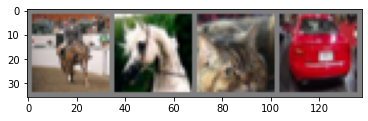

In [7]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

## Train CNN

In [8]:
import sys, os
import torch.nn as nn
import torch.nn.functional as F

In [9]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party')

In [10]:
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet

In [11]:
net = SimpleConvolutionalNetwork()

In [12]:
import torch.optim as optim

# Define the model parameters
lr = 0.001
n_epoch = 10
n_classes = len(classes)
batch_size = 100


# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
Loss = nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [13]:
seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [14]:
def get_train_loader(batch_size):
    return th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

train_loader = get_train_loader(batch_size)

# Use larger batch size for validation to speed up computation
val_loader = th.utils.data.DataLoader(train_set, batch_size=1000, sampler=val_sampler,
                                          num_workers=num_workers)

test_loader = th.utils.data.DataLoader(test_set, batch_size=1000, sampler=test_sampler,
                                         num_workers=num_workers)

In [15]:
seed = 2023
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_mc = CES_multiClass(net, device, train_loader, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader, criterion=criterion,optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 100
n_epochs= 10
learning_rate= 0.001


In [16]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc.full_train(save_dir = './models', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 2.30 train_acc: 11.50% took: 2.80s
Epoch 1 of 10, 20% 	 train_loss: 2.27 train_acc: 12.50% took: 0.05s
Epoch 1 of 10, 30% 	 train_loss: 2.16 train_acc: 25.50% took: 0.05s
Epoch 1 of 10, 40% 	 train_loss: 2.09 train_acc: 25.00% took: 0.04s
Epoch 1 of 10, 50% 	 train_loss: 2.02 train_acc: 28.00% took: 0.04s
Epoch 1 of 10, 60% 	 train_loss: 2.06 train_acc: 27.50% took: 0.05s
Epoch 1 of 10, 70% 	 train_loss: 2.04 train_acc: 33.00% took: 0.03s
Epoch 1 of 10, 80% 	 train_loss: 1.89 train_acc: 36.50% took: 0.05s
Epoch 1 of 10, 90% 	 train_loss: 1.93 train_acc: 28.50% took: 0.04s
Epoch 1 of 10, 100% 	 train_loss: 1.90 train_acc: 33.00% took: 0.04s
val_loss = 1.95 val_acc = 30.80%
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 1.87 train_acc: 34.50% took: 2.65s
Epoch 2 of 10, 20% 	 train_loss: 1.89 train_acc: 35.50% took: 0.05s
Epoch 2 of 10, 30% 	 train_loss: 1.77 train_acc: 39.00% took: 0.03s
Epoch 2 of 10, 40% 	 train_loss: 1.79 train_acc: 32.50%

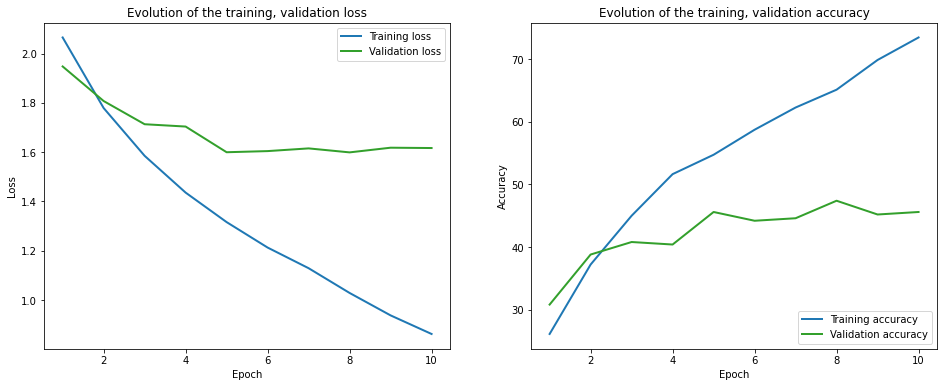

In [29]:
train_loss = CES_mc.train_loss_history
train_acc = CES_mc.train_acc_history
val_loss = CES_mc.val_loss_history
val_acc = CES_mc.val_acc_history


x = np.arange(1, len(train_loss) + 1)

fig,axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')
axs[0].set_title("Evolution of the training, validation loss")

axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')
axs[1].set_title("Evolution of the training, validation accuracy")
plt.show()

# Select best models and compute prediction sets


## Check the benchmark model
select_model function will choose the best model for given test point, if no test point
is given, it will output the best model selected ONLY based on validation data, which
serves as an benchmark model.

In [30]:
# check the benchmark model
bm_loss, bm_model, loss_history = CES_mc.select_model()

In [31]:
# Benchmark model corresponds to the one with smallest validation loss
print('Benchmark best loss is: {:.3f}'.format(bm_loss))
print('Benchmark best model is saved in:', bm_model)

Benchmark best loss is: 1.599
Benchmark best model is saved in: ./models\model8.pth


# Compute prediction sets

In [32]:
from inference import Conformal_PSet

alpha = 0.1
n_classes = len(classes)
model_list = CES_mc.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet = Conformal_PSet(net, device, val_loader, n_classes, model_list, alpha,random_state = 2023)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.83s/it]

Initialization done!
Calibration (one time effort) takes:28.29s.


In [33]:
# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

In [42]:
# Pick the best model for each test point
start = time.time()
best_loss, best_model, test_val_loss_history = CES_mc.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.33it/s]

Loading model 1 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.69it/s]

Loading model 2 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.76it/s]

Loading model 3 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.49it/s]

Loading model 4 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.27it/s]

Loading model 5 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 231.86it/s]

Loading model 6 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.04it/s]

Loading model 7 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.51it/s]

Loading model 8 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.98it/s]

Loading model 9 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.92it/s]

selecting models takes: 44.92013645172119


In [43]:
# Get the marginal conformal pvalues 
pset_m= C_PSet.pred_set(inputs, best_model, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc = C_PSet.pred_set(inputs, best_model, marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.11it/s]


Finished computing marginal prediction sets for 1000 test points.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.08it/s]

Finished computing label conditional prediction sets for 1000 test points.


In [44]:
def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [45]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m, labels.numpy())
print('='*50)
evaluate_conditional(pset_m, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       91.700%
Average size:            4.857
Average size | coverage: 4.880
Conditional coverage for label plane:       88.350%
Average size:            4.388
Average size | coverage: 4.264
Conditional coverage for label car:       93.258%
Average size:            4.022
Average size | coverage: 4.060
Conditional coverage for label bird:       88.000%
Average size:            5.360
Average size | coverage: 5.523
Conditional coverage for label cat:       91.262%
Average size:            5.340
Average size | coverage: 5.436
Conditional coverage for label deer:       93.333%
Average size:            5.478
Average size | coverage: 5.548
Conditional coverage for label dog:       91.860%
Average size:            5.047
Average size | coverage: 5.139
Conditional coverage for label frog:       97.321%
Average size:            4.946
Average size | coverage: 4.917
Conditional coverage for label horse:       94.118%
Average size:            5.11

In [46]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       91.800%
Average size:            4.888
Average size | coverage: 4.907
Conditional coverage for label plane:       83.495%
Average size:            4.573
Average size | coverage: 4.477
Conditional coverage for label car:       96.629%
Average size:            3.989
Average size | coverage: 3.977
Conditional coverage for label bird:       92.000%
Average size:            5.230
Average size | coverage: 5.293
Conditional coverage for label cat:       90.291%
Average size:            5.485
Average size | coverage: 5.624
Conditional coverage for label deer:       93.333%
Average size:            5.300
Average size | coverage: 5.333
Conditional coverage for label dog:       90.698%
Average size:            5.035
Average size | coverage: 5.141
Conditional coverage for label frog:       90.179%
Average size:            5.196
Average size | coverage: 5.188
Conditional coverage for label horse:       97.059%
Average size:       

In [37]:
C_PSet.alpha_calibrated[6]

0.059232441975474316

In [38]:
C_PSet.alpha_calibrated_lc[6]

array([0.07130931, 0.02887572, 0.02493679, 0.04300576, 0.0484343 ,
       0.07992018, 0.22433368, 0.09077377, 0.05092235, 0.04250795])